<img src="plane.jpg">

# **A comparative analysis of plane boarding strategy**

by Erica Brisigotti (Università degli Studi dell'Insubria - ebrisigotti@studenti.uninsubria.it)

In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# **Abstract**

Airlines all around the world implement boarding strategies that regulate the flow of passengers between the terminal gate and the airplane. Many airports are equipped with jetways that allow passengers to board directly from terminal to aircraft to simplify the process and increase passenger comfort.

Different strategies were developed to make the boarding process via jetway more efficient. Despite their differences, they all aim to shorten the total boarding time and, consequently, Turn-Around Time: TAT is the time required to unload an airplane after it arrives at the gate and to prepare it for departure again and is strictly related to profitability. In fact, when the plane is stationary on the ground it isn’t making any revenue but rather adding up other costs.

Despite the efforts to shorten TAT as much as possible, there are obstacles to the smooth running of boarding strategies. Interference can occur when passengers are blocking each other from moving on or taking a seat. Jamming takes on 2 main forms, full-stops and seat shuffling:
- **full-stops** happen when a passenger stops to load their bag and a queue of people builds up in the aisle. The flow of passengers resumes only when the first passenger is seated, only to stop again when another passenger is in the way.
- **seat shuffling** is one of the bulkiest yet avoidable additions to the time that each passenger needs to occupy the respective seat: it occurs when passengers in middle or window seats can't sit down right away because already seated people are in their way. The latter need to stand up and temporarily queue up in the aisle to solve the situation.

The goal of the following Jupyter notebook is to identify the optimal plane boarding strategy that airlines could implement to make the plane boarding process as efficient as possible, since *boarding a plane always seems to take longer than it should* $^{(1)}$.

# **Introduction**
In the following section I'm going to analyze the elements that influence the boarding time of the common type of narrow-body airliner: it consists of a plane with only one aisle, carrying from 4 to 6 passengers per row and fewer than 300 passengers: this type of plane usually has only one entry located in the front of the aircraft.

In [2]:
# we're going to analyze planes with only one isle
print('we suppose:')
# we set a number of rows within the plane
n_rows=30
print('- there are {:d} rows of seats on the plane.'.format(n_rows))
# and the number of seats per row
n_seats_per_row=6
print('- there are {:d} seats on each row the plane.'.format(n_seats_per_row))
# the total number of passengers is given by
n_tot=n_rows*n_seats_per_row
print('- on the plane there are a total of {:d} seats.'.format(n_tot))
# we also initialize the length of the plane:
tot_space=50 # m
print('- the plane is {:.2f} meters long.'.format(tot_space))
# and space taken up by each row
space_per_row=tot_space*0.5/n_rows # m
print('- each row of seats on the plane takes up {:.2f} meters.'.format(space_per_row))
seats=np.zeros((n_tot,2))

we suppose:
- there are 30 rows of seats on the plane.
- there are 6 seats on each row the plane.
- on the plane there are a total of 180 seats.
- the plane is 50.00 meters long.
- each row of seats on the plane takes up 0.83 meters.


In such planes, the total boarding time for each passenger $t_{tot}$ is the sum of the following contributions:
$$ t_{tot} = t_{walk} + t_{luggage} + t_{shuffle} $$
- the **walking time** $t_{walk}$ is the time required for the passenger to walk from the entry of the economy section to their respective seat: walking time is directly proportional to the distance traveled (which is related to the row in which the passenger is seated since the entry is in the front). This process also has a random element to it because of the walking speed of the passenger, which varies based on multiple factors such as their age, health and weight of their carryon.
- once the passenger has reached the desired row, **bag time** $t_{luggage}$ starts: during such time the passenger has to load their carry-on in the respective overhead storage. Fluctuations may occur because of the size of the carry-ons (their own or the ones already present in the overhead storage) and because of other distractions, such as time grabbing whatever object will be needed during the flight (e.g. laptops or books).
- the third and last component is the aforementioned **shuffling time** $t_{shuffle}$: this process is directly proportional to the number of already seated that need to stand up (which varies from 0 to 2), but also random because the time needed for each neighbor to move around is different.

Because of their random nature, each one of the aforementioned values will be randomly generated based on a Gaussian distribution: its mean value and standard deviation will be assigned based on empirical observation in the following subsections.


## **Walking Time**

Firstly, I want to estimate the time necessary for each passenger to walk from the entry of the economy section of the cabin to their respective seat.

The first observation is based on the hypothesis that the plain has only one entrance, located in the front:
the indexing of the rows also goes front to back, resulting in passengers with lower row numbers needing less time to board. The walking time $t_{walk}$ is, therefore, a function of the net number of rows traveled $d$ that the passenger is assigned:
$$ t_{walk} =k \cdot d $$
- the net number of rows traveled $d$ can be easily calculated as the difference between the row that each passenger occupies and the previous full-stop point. The previous full-stop point is the lowermost row occupied by one of the passengers that got to seat during the previous full-stop. To ensure positive values of distance (and therefore time) I take the maximum value between the aforementioned difference and 0 (meaning that the respective row was already reached during the previous full-stop but the further steps weren't allowed):
$$ d=max\left\{ \left( r_i - s \right) , 0 \right\} \;\; \wedge \;\; min \left\{ r_j \, : j \text{ sat down during previous full-stop} \right\} $$ 

- the multiplicative factor $k$ between the forementioned quantities is dimensionally s/row. This factor must now take into account the difference in walking pace that may occur among passengers due to age, health and weight of their carry-on. For these reasons, the factor will be randomly extracted based on a Gaussian distribution of known mean value $\bar{k}$ and standard deviation $\delta k$.


The values for $\bar{k}$ and $\delta k$ will be established based on the following empirical observation:
- the space taken up by each row of seats $l$ is obtained by dividing the length of the cabin $L$ and the number of rows $n_{rows}$:
$$l=\frac{L}{n_{rows}}$$
- the average velocity for a person weighted down by their luggage $^{(4)}$ is $v \sim (4.5 \pm 0.5) $ km/h $\sim (1.25 \pm$ 0.14) m/s of a passenger moving along the aisle while carrying their luggage.}

By dividing these quantities (as stated by the time law of uniform rectilinear motion) I'm able to find the average time require to step from one row to the following (i.e. the average factor $k$):
$$ \bar{k} =\frac{\bar{T}}{n_{rows}}=\frac{L}{\bar{v} \cdot n_{rows}}=\frac{l}{\bar{v}} 
\hspace{1cm} \Rightarrow \hspace{1cm} \delta k = \left| \frac{\partial \bar{k}}{\partial \bar{v}} \right| \delta v = \frac{l}{\bar{v}^2} \delta t $$

In [3]:
mean_velocity=4.5/3.6 # m/s
delta_velocity=0.5/3.6 # m/s
mean_k=space_per_row/mean_velocity # s/row
delta_k=space_per_row*delta_velocity/mean_velocity**2 # s/row
print('- the average value and standard deviation for the factor k distribution are {:.2f} and {:.2f} seconds/row.'.format(mean_k,delta_k))

- the average value and standard deviation for the factor k distribution are 0.67 and 0.07 seconds/row.


## **Luggage Time**

The time needed for passengers to position their luggage in their respective overhead storage is purely random and also Gaussian distributed. Passengers can happen to have little to no luggage with them and take very little time or, on the other hand, take plenty of time struggling to fit their luggage with the other ones and pulling out the personal belongings they need during the flight. 

After a series of experiments and measurements $\left\{ x_i \right\}$, I was able to estimate the mean value and standard deviation for the luggage time distribution as follows:

$$ \bar{t}_{luggage}=\frac{1}{N}\sum_{i=1}^N x_i \hspace{3cm} 
\delta t_{luggage}=\sqrt{\frac{1}{N} \sum_{i=1}^N (x_i-\bar{t}_{luggage})^2}
$$

In [4]:
data_luggage=np.array([5.8,5.3,8.7,8.5,8.9,  6.3,7.7,9.8,11.7,9.3,  7.2,6.5,9.2,10.4,9.3]) # s
mean_luggage=np.mean(data_luggage) # s
delta_luggage=np.std(data_luggage) # s
print('- the average value and standard deviation of the luggage time distribution are {:.2f} and {:.2f} seconds.'.format(mean_luggage,delta_luggage))

- the average value and standard deviation of the luggage time distribution are 8.31 and 1.74 seconds.


## **Shuffle Time**

Once the passenger has reached their row, one last step may occur: seat shuffling is needed whenever the passenger is assigned the middle or window seat and its already-seated neighbors are in its way: the latter need to stand up, temporarily occupy the aisle (to allow the newly arrived to take their seat) and sit down again. The total shuffling time depends on the number of people bothered within the process and also on their respective agility, which is random and gaussian distributed:
$$ t_{shuffle}=\sum_{bothered \; people} t_{shuffle}^{person}  $$
where the number of people bothered is less than or equal to 2, and each $t_{shuffle}^{person}$ will be extracted from the same Gaussian distribution.

The mean value and standard deviation of the shuffling time distribution were computed based on a series of experiments and measurements $\left\{ y_i \right\}$:

$$ \bar{t}_{shuffle}=\frac{1}{N}\sum_{i=1}^N y_i \hspace{3cm} 
\delta t_{shuffle}=\sqrt{\frac{1}{N} \sum_{i=1}^N (y_i-\bar{t}_{shuuffle})^2}
$$

In [5]:
data_shuffle=np.array([5.5,6.7,4.2,3.7,5.2,  8.5,8.2,8.3,9.9,8.8,  5.1,6.6,6.7,5.0,6.3]) # s
mean_shuffle=np.mean(data_shuffle) # s
delta_shuffle=np.std(data_shuffle) # s
print('- the average value and standard deviation of the shuffle time distribution are {:.2f} and {:.2f} seconds.'.format(mean_shuffle,delta_shuffle))

- the average value and standard deviation of the shuffle time distribution are 6.58 and 1.77 seconds.


# **Implementation**

As seen in the previous section, the total boarding time for each passenger is:
$$ t_{tot} = k\cdot d + t_{luggage} + \sum_{bothered \; people} t_{shuffle}^{person} $$
where $k$, $t_{luggage}$ and each $t_{shuffle}^{neighbor}$ are random quantities that will be extracted (from the respective distribution) for each passenger. 

Functions will be used extensively to simplify the repetition necessary to get a statistically significant analysis: each process consists of
1. selecting the seats
2. isolating the boarding groups
3. calculating the boarding time for every strategy analyzed

and will be repeated $n_{reps}$ times: the results of every iteration will then be saved in an array to later be presented (in the Result section) as in the form of frequency histograms. The latter will be compared and contrasted to deduce the topics of the Discussion section.

In [6]:
n_reps=500
n_methods=5
storage=np.zeros((n_reps,n_methods))

In [7]:
def get_seats():
    # this function lists all the possible combinations of rows and seat within the row in ascending order
    r=np.linspace(0,n_rows-1,n_rows,dtype=int)
    s=np.linspace(0,n_seats_per_row-1,n_seats_per_row,dtype=int)
    # 0 and 5 are window seats, 1 and 4 are middle seats and 2 and 3 are aisle seats
    # I store said combinations in a 2-dimensional numpy array
    seats=np.zeros((n_tot,2),dtype=int)
    seats[:,0]=np.repeat(r,n_seats_per_row)
    seats[:,1]=np.tile(s,n_rows)
    # the particular choice of orientation of the array is based on the properties of the function I'm about to use
    # (numpy.random.shuffle only shuffles the array along the first axis of a multi-dimensional array)
    # that I later shuffle to simulate the random boarding order
    return seats

In [8]:
def get_full_stop_groups(boarding_order):
    # this function locates when the boarding queue runs into full-stops: they happen when a passenger is in the
    # way of the one just after hiim (i.e. when the next person has a greater or equal row index). 
    # first, I initialize a counter that will identify each passenger in the (not necessarily ordered) queue
    i=0
    # the use of lists as an outer container for all the desired groups (which are, singularly, numpy arrays)
    # follows from the irregular/unpredictable size of each group (which forbids the use of numpy.concatenate
    # or numpy.vstack)
    groups=[]
    # until every passenger has been examined
    while i<n_tot:
        # I initialize an array that will contain the indexes of the people that can sit down during the same full-stop
        temp=np.array([i])
        # I examine the following passenger
        j=i+1
        # to see if such people exist: sitting down during the same full-stop is equivalent to having decreasing values of rows
        while (j<n_tot) and (boarding_order[j,0]<boarding_order[(j-1),0]):
            # whenever I find said people, I save their index in the array I previously initialized
            temp=np.concatenate((temp,[j]))
            # and increment the second index on which the internal loop is based on
            j+=1
        # once I find all the people in the same full-stop group, I save the array of indexes
        groups.append(temp)
        # and update the index to avoid looking again at the same elements
        i=j
    return groups

In [9]:
def get_boarding_time(boarding_order,groups):
    # this function calculates the total boarding time by combining all the elements previously explained
    # first of all, for each passenger I randomly extract
    # - the walking factor
    k_time=np.random.normal(mean_k,delta_k,n_tot)
    # - the luggage time
    luggage_time=np.random.normal(mean_luggage,delta_luggage,n_tot)
    # - the shuffling time: in this case, the number of values that will end up being used is dependent
    #   on whether there are people in the way of the passenger seated (and how many of them there are,
    #   from 0 to 2)
    potential_shuffle_time=np.random.normal(mean_shuffle,delta_shuffle,(n_tot,2))

    # before looping, I initialize two matrix that will help me track :
    # 
    # - a null matrix that will help me track which seats are progressively occupied (once the passenger will be seated,
    #   the respective element will be set to one)
    occupied=np.zeros((n_rows,n_seats_per_row),dtype=int)
    # - an array to store the shuffle time, that will be calculated below because of its dependence on how many people are already
    #   seated boarding order (which is strictly related to boarding time):
    actual_shuffle_time=np.zeros((n_tot,1))
    # - an array to store the walking time, that will also be calculated below since it's closely related to the previous grouping order
    walk_time=np.zeros((n_tot,1))
    # - an array to store the total time that each passenger would require to board singularly
    total_time=np.zeros((n_tot,1))
    # - an array to store the actual time that each boarding group requires
    determining_time=np.zeros((len(groups),1))
    # - a temporary variable (to be updated at the end of every operation) to store the lowermost row of the previous full-stop group 
    #   (which is needed to compute the walking time)
    previous_stop=0
    # within each full-stop group:
    for l,g in enumerate(groups):
        # within each group
        # because of the "boolean" 0/1 structure of the matrixes that tract occupation, I get easily get the number of
        # people that need to shuffle by summing over the people that are in the way (i.e. the people that have lower
        # indexes than the new passenger)
        # I examine each passenger
        for i in g:
            # I temporarily extract their coordinates (to improve the readability of the code)
            temp_r=boarding_order[i,0]
            temp_s=boarding_order[i,1]
            # if the passenger is in middle (indexes 1 or 4) or window seat (indexes 0 or 5), I count how many already-seated
            # people are in their way:
            if temp_s<2: 
                n=(occupied[temp_r,temp_s:4]).sum()
            elif random_seats[i,1]>3:
                n=(occupied[temp_r,3:temp_s]).sum()
            # if the passenger has an aisle seat, no shuffling takes place
            else:
                n=0
            # one I know how many people shufle, I can sum the correct amount (n) of values (previously randomly extracted)
            # that need to be taken into account
            actual_shuffle_time[i]=(potential_shuffle_time[temp_r,0:(n)]).sum()
            # I then update the occupation matrix:
            occupied[temp_r,temp_s]+=1
            # and the walking time
            walk_time[i]=np.max([(temp_r-previous_stop),0])*k_time[i]
            # I can finally calculate the total boarding time that each passenger would singularly require
            total_time[i] = walk_time[i] + luggage_time[i] + actual_shuffle_time[i]
        # thankfully, because of the full-stop groups structure, I don't need to sum every single boarding time:
        # the time needed for each full-stop group to can be approximated with the maximum time spent by a passenger of said group.
        # Such value is therefore saved as the determining time for the group
        determining_time[l]=np.max(total_time[g])
        # lastly, I update the temporary variable needed for the next iteration
        previous_stop=np.min(boarding_order[g,0])
    
    # ultimately, I get the actual net boarding time for the entire cabin by adding up each determining time previously calculated
    actual_time=determining_time.sum()
    return actual_time #s

## **The Random strategy**

The random strategy prescribes that passengers line up at the gate counter and are admitted for boarding in the order they arrive. \
This method can also correctly reproduce other boarding strategies that don't involve jetway-less, but rather walking or busses, and that are commonly used in smaller airports.

In [10]:
def get_random_seats():
    # this function randomly shuffles (all at once) the possible combinations of seats to reproduce the Random boarding strategy
    random_seats=get_seats()
    np.random.shuffle(random_seats)
    return random_seats

In [11]:
# at every iteration
for rep in range(n_reps):
    # I get a fresh random configuration of seats
    random_seats=get_random_seats()
    # for which I calculate the net total boarding time
    random_time=get_boarding_time(random_seats,get_full_stop_groups(random_seats))
    # I show an example to give an idea of the scale:
    if rep==0:
        print('ex. random strategy time: ',random_time,' seconds = ',random_time/60,' minutes.')
    storage[rep,0]=random_time

ex. random strategy time:  1941.8401057004735  seconds =  32.36400176167456  minutes.


## **The back-to-front strategy**

Aircraft rows are divided into zones (each zone grouping a certain number of rows). In this particular method, the last zone in the back is the first to be seated. Next comes the furthest yet unoccupied zone in the back, continuing like this until the first section in the front is occupied. \
The advantage of this method is that passengers who are boarding at the back and the front will not interfere with each other.

In [12]:
def get_back_to_front_seats(bg=5):
    # this function divides the passenger into a certain amount of boarding groups (bg) based on their row coordinate:
    # once they're selected
    btf_seats=get_seats()
    # I compute the size of each boarding group
    bs=int(n_tot/bg)
    # and use a for-loop to temporarily consider one group at a time
    for i in range(bg):
        # once selected, I randomly shuffle them
        np.random.shuffle(btf_seats[bs*i:(bs*(i+1))])
    # lastly, the vector is flipped to get the back-to-front desired order of boarding
    np.flip(btf_seats)
    return btf_seats

In [13]:
# at every iteration
for rep in range(n_reps):
    # I get a fresh random configuration of seats
    btf_seats=get_back_to_front_seats()
    # for which I calculate the net total boarding time
    btf_time=get_boarding_time(btf_seats,get_full_stop_groups(btf_seats))
    # I show an example to give an idea of the scale:
    if rep==0:
        print('ex. back-to-front strategy time: ',btf_time,' seconds = ',btf_time/60,' minutes.')
    storage[rep,1]=btf_time

ex. back-to-front strategy time:  1437.204233920329  seconds =  23.95340389867215  minutes.


## **The window-middle-aisle strategy**

The window-middle-aisle approach to boarding divides the passenger into three groups: window seats are occupied first, then middle seats are filled and passengers near the aisle go last.
This method is equivalent to applying the random method three times on three subsamples, yet avoids any contribution to shuffling time.

In [14]:
def get_wma_seats():
    # this function divides and separately shuffles the passegers based on their window, middle or aisle seating:
    # (0 and 5 are window seats, 1 and 4 are middle seats and 2 and 3 are aisle seats)
    # once the seated are selected
    wma_seats=get_seats()
    # I first select people in window seats
    a=wma_seats[np.logical_or(wma_seats[:,1]==0,wma_seats[:,1]==5)]
    # and randomly shuffle them
    np.random.shuffle(a)
    # I then select people in middle seats
    b=wma_seats[np.logical_or(wma_seats[:,1]==1,wma_seats[:,1]==4)]
    # and randomly shuffle them too
    np.random.shuffle(b)
    # last come the aisle seat, which are selected
    c=wma_seats[np.logical_or(wma_seats[:,1]==2,wma_seats[:,1]==3)]
    # as well as, you guessed it, randomely shuffled
    np.random.shuffle(c)
    # finally, I concatenate the previously created variables to ensure the desire boarding order
    wma_seats=np.concatenate((a,b,c))
    return wma_seats

In [15]:
# at every iteration
for rep in range(n_reps):
    # I get a fresh random configuration of seats
    wma_seats=get_wma_seats()
    # for which I calculate the net total boarding time
    wma_time=get_boarding_time(wma_seats,get_full_stop_groups(wma_seats))
    # I show an example to give an idea of the scale:
    if rep==0:
        print('ex. window-middle-aisle strategy time: ',wma_time,' seconds = ',wma_time/60,' minutes.')
    storage[rep,2]=wma_time

ex. window-middle-aisle strategy time:  1456.1293982330158  seconds =  24.268823303883597  minutes.


## **The Steffen (perfect) strategy**

The Steffen (perfect) strategy is, theoretically, the most efficient method that could be implemented and requires an exact order or boarding: back to front, on alternating rows, on alternating sides, from the windows in. In this way, full-stops are minimized and seat shuffling is prevented.

In [16]:
def get_steffen_seats():
    # this fuction lists the precise order of seats that is behid the Steffen boardin method 
    # (0 and 5 are window seats, 1 and 4 are middle seats and 2 and 3 are aisle seats)
    # firstly, I list all the possible combinations of rows and seat within the row
    r1=np.tile(np.arange(n_rows,0,-2)-1,2)
    r2=np.tile(np.arange(n_rows-1,0,-2)-1,2)
    r3=np.concatenate((r1,r2))
    # I store said combinations in a 2-dimensional numpy array
    steffen_seats=np.zeros((n_tot,2),dtype=int)
    steffen_seats[:,0]=np.tile(r3,3)
    steffen_seats[:,1]=np.repeat(np.array([0,5,0,5,1,4,1,4,2,3,2,3]),int(n_rows/2))
    return steffen_seats

In [17]:
# at every iteration
for rep in range(n_reps):
    # I get the specific configuration of seats I want
    steffen_seats=get_steffen_seats()
    # for which I calculate the net total boarding time
    steffen_time=get_boarding_time(steffen_seats,get_full_stop_groups(steffen_seats))
    # I show an example to give an idea of the scale:
    if rep==0:
        print('ex. Steffen strategy time: ',steffen_time,' seconds = ',steffen_time/60,' minutes.')
    storage[rep,3]=steffen_time

ex. Steffen strategy time:  355.49485229274546  seconds =  5.924914204879091  minutes.


## **Reverse-pyramid strategy**

The reverse-pyramid method aims to be the best compromise between the implementation of the Steffen (perfect) method and enforceability. Boarding groups are implemented to boarding from the outer back to the inner front of the cabin. \
This method is a combination of Back-to-Front and Window-to-Aisle, since window and middle passengers near the back of the plane board first, while those with aisle seats near the front are called last allowing for little to no seat-shuffling.

In [18]:
def get_reverse_pyramid():
    # this function isolates the groups of passengers predicted by the reverse-pyramind boarding method and randomly shuffles
    # the people within them, focussing on one side of the plane: because boarding groups are intrinsic to this process, I act
    # directly on them
    # firstly, I initialise a list that will contain the indexes of the seats divided by group
    groups=[0]*(2*n_rows)
    # similarly, I initialise a vector where I will be saving the seats in the desired order
    seats=np.array([0,0])
    # focussing on the first side
    # for each group
    for a,d in enumerate(np.arange(n_rows-1,-1,-1)):
        # I save a temporary variable
        temp=[]
        # and select the combination of seats, taking into account the adjustments needed
        # - in the last row of seats (in the back)
        if d==(n_rows-1):
            temp=np.array([[d,5],[d,4],[d-1,5]])
        # - in the first row (in the front)
        elif d==0:
            temp=np.array([[d,3],[d,4],[d+1,3]])
        # - in general
        else:
            temp=np.array([[d-1,5],[d,4],[d+1,3]])
        # now that I have the seats, I just need to shuffle them to mimic real behaviour
        np.random.shuffle(temp)
        # I then save the indexes of the seats
        groups[a]=np.array([0,1,2])+3*a
        # and the seats coordinates:
        for i in range(3):
            t=temp[i,:]
            seats=np.vstack((seats,t))
    # now similarly, for the other side:
    for a,d in enumerate(np.arange(n_rows-1,-1,-1)):
        temp=[]
        if d==(n_rows-1):
            temp=np.array([[d,0],[d,1],[d-1,0]])
        elif d==0:
            temp=np.array([[d,2],[d,1],[d+1,2]])
        else:
            temp=np.array([[d-1,2],[d,1],[d+1,0]])
        np.random.shuffle(temp)
        groups[a+n_rows]=np.array([0,1,2])+3*a+n_rows*3
        for i in range(3):
            t=temp[i,:]
            seats=np.vstack((seats,t))
    # lastly, I delete the extra element that came from my particular choice of initialization (due to me wanting to use
    # np.vstack with 2-dimensional arrays) 
    seats=seats[1:]
    return groups, seats

In [19]:
# at every iteration
for rep in range(n_reps):
    # I get the specific configuration of seats I want
    groups,rp_seats=get_reverse_pyramid()
    # for which I calculate the net total boarding time
    rp_time=get_boarding_time(rp_seats,groups)
    # I show an example to give an idea of the scale:
    if rep==0:
        print('ex. Reverse-pyramid strategy time: ',rp_time,' seconds = ',rp_time/60,' minutes.')
    storage[rep,4]=rp_time

ex. Reverse-pyramid strategy time:  1044.8381002328683  seconds =  17.413968337214474  minutes.


# **Results**

First of all, I’m interested in getting an overall idea of the data that was just collected:

In [20]:
n_bins=int(np.sqrt(n_reps))
colors=['deeppink','orange','lawngreen','skyblue','mediumpurple']
labels=['random','back-to-front','window-middle-aisle','Steffen','reverse pyramid']

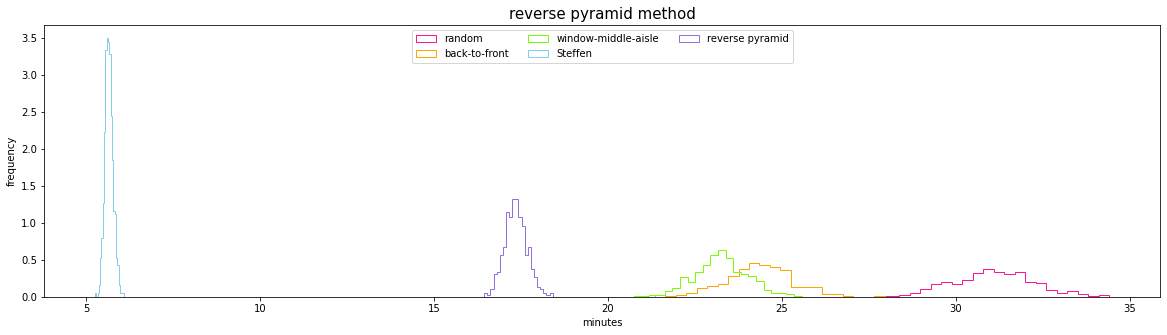

In [21]:
fig1,ax1=plt.subplots(1,1,figsize=(20,5))
# I plot every frequency histogram in the same figure to compare the different scales
for method in range(n_methods):
    ax1.hist(storage[:,method]/60,bins=n_bins,histtype='step',density=True,label=labels[method],color=colors[method])
ax1.legend(fontsize=10,loc='upper center',ncol=3)
ax1.set_title(labels[method]+' method',fontsize=15)
ax1.set_xlabel('minutes')
ax1.set_ylabel('frequency')
plt.show()

Let's now analyze each peak in detail: for each one, I plot the frequency histogram and fit it based on a Gaussian model to get a mean value and a standard deviation. These will allow for a quantitative analysis

the mean value and standard deviation of the random method are 31.08 and 1.18 minutes.
the mean value and standard deviation of the back-to-front method are 24.37 and 0.90 minutes.
the mean value and standard deviation of the window-middle-aisle method are 23.23 and 0.73 minutes.
the mean value and standard deviation of the Steffen method are 5.63 and 0.11 minutes.
the mean value and standard deviation of the reverse pyramid method are 17.32 and 0.32 minutes.


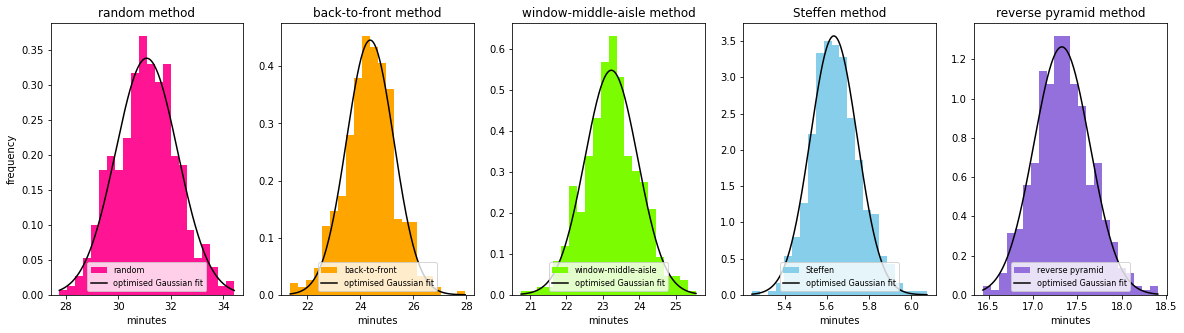

In [22]:
def my_gaussian(x,mean,sigma):
    return np.exp(-0.5*(x-mean)**2/sigma**2)/np.sqrt(2*np.pi)/sigma
starting_points=[ [31,1], [25,1], [24,1.5], [5.6,0.2],[17.5,0.5] ]
details=np.zeros((2,n_methods))

fig2,ax2=plt.subplots(1,n_methods,figsize=(20,5))
# for every method
for method in range(n_methods):
    # I show the frequency histogram
    y,bins,_=ax2[method].hist(storage[:,method]/60,bins=n_bins,density=True,label=labels[method],color=colors[method])
    # I then use the outputs from the histogram to get the quantites for the fit
    x=(bins[1:]+bins[:-1])/2
    x_fit=np.linspace(np.min(bins),np.max(bins),300)
    parameters, covariance = curve_fit(my_gaussian, x, y,p0=starting_points[method])
    print('the mean value and standard deviation of the {:} method are {:.2f} and {:.2f} minutes.'.format(labels[method],
                                                                                                              parameters[0],parameters[1]))
    # I then show said fit
    ax2[method].plot(x_fit, my_gaussian(x_fit, parameters[0], parameters[1]),color='k',label = "optimised Gaussian fit" )
    # save the parameters just estimated
    details[:,method]=parameters
    ax2[method].legend(fontsize=8,loc='lower center')
    ax2[method].set_title(labels[method]+' method',fontsize=12)
    ax2[method].set_xlabel('minutes')
    if method==0:
        ax2[method].set_ylabel('frequency')

# **Discussion**

In the following section I'm going to go over the results that were just presented to contextualize them:
- first of all, the **random boarding method** seems to be the worst performing one in terms of net total time boarding time. Its wide use helps contextualize the other key element of this process, feasibility, which is maximized in the random strategy. This approach intrinsically contemplates the presence of random passengers to board earlier that choose to pay more and of families that will naturally want to board together.
- the **back-to-front strategy** and the **window-middle aisle method** tie at third place in terms of total time. Time-efficiency is improved (compared to the random boarding method) thanks to some form of regulation: both strategies are reasonably easy to implement but those same regulations might interfere with premium early boarding or keeping families together. So, despite being a good compromise, these methods might score low in satisfaction.
- the **reverse-pyramid method** takes second place in terms of the net total boarding time. This method naturally leads to a division into proper boarding groups that could be assigned directly then the seat, so this method is still relatively easy to implement. Despite that, the larger number of boarding groups and the little flexibility provided by this system could lead to low satisfaction rates.
- the **Steffen strategy** is the most time efficient, yet the most rigid and difficult to enforce. For this reason, it's difficult to predict the degree of customer satisfaction that could come out of this compromise. The little to no feasibility is likely to prevent airlines from assuming it as a standard procedure.

The most realistic yet dissatisfying conclusion is that airlines will be more likely to use the lengthier yet easy-to-implement methods, such as the back-to-front or the window-middle-aisle strategies (but also the random one), since more elaborate alternatives would require further supervision from the flight crew. 

Lastly, a few words need to be said for intellectual honesty: of course, the results I just discussed and the conclusions that were just made were the outcomes of a simulation. Every simulation is strictly dependent on the abstraction and modelization of the problem, so different abstractions could lead to different results.
To avoid this layer of complications, real-life data could be analyzed. Sadly, up until this moment, interest in the data collection hasn't been high and the little data available is inconsistent between the different strategies analyzed (since each airline usually has one standard procedure).
Hopefully, in the future, larger and more consistent datasets regarding plane boarding will be available, to help establish both the actual best boarding strategy and the best way to simulate this phenomenon.

# **References**
1. overall: What's the Best Plane Boarding Plan? | MythBusters | YouTube (https://www.youtube.com/watch?v=ss1S3-Kv6R8)
2. overall: The Better Boarding Method Airlines Won't Use | CGP Grey | YouTube (https://www.youtube.com/watch?v=oAHbLRjF0vo&t=89s)
3. on Narrow-body AirCrafts: https://en.wikipedia.org/wiki/Narrow-body_aircraft
4. on Average Speed with Luggage: https://thewanderingwanderluster.com/common-faqs-for-the-camino-de-santiago/
5. on Steffen strategy: Experimental test of airplane boarding methods (https://arxiv.org/abs/1108.5211)
6. on Steffen strategy: https://en.wikipedia.org/wiki/Steffen_Boarding_Method